In [2]:
using Distributed

In [3]:
workers()

1-element Vector{Int64}:
 1

In [4]:
addprocs(30)
;

In [5]:
nworkers()

30

In [6]:
@everywhere using FastaIO
@everywhere using MultivariateStats
@everywhere using LinearAlgebra
@everywhere using DelimitedFiles
@everywhere using StatsBase
@everywhere using DCAUtils
@everywhere using PyPlot
@everywhere using Random
@everywhere using Printf
@everywhere using LinearAlgebra
@everywhere using GLM
@everywhere using Statistics
@everywhere using KitMSA

In [7]:
@everywhere include("../src/read_write.jl")
@everywhere include("../src/energy.jl")
@everywhere include("../src/msa_tools.jl")
@everywhere include("../src/extra_tools.jl")

In [7]:


function amino_seq2dna_seq(seq)
    seq_dna=[]
    for a in seq
        push!(seq_dna, sample(amino2cod[a]))
    end
    return seq_dna
end

function dna_seq2amino_seq(seq_dna)
    new = []
    for a in seq_dna
        push!(new, cod2amino[a])
    end
    return new
end

function pairwise_hamming(msa::Array{Int8,2})
    num_seqs = size(msa, 1)
    pairwise_distances = Array{Int,1}(undef, num_seqs*(num_seqs-1)÷2)
    idx = 1
    for i in 1:num_seqs-1
        for j in i+1:num_seqs
            dist = KitMSA.my_hamming(msa[i,:], msa[j,:])
            pairwise_distances[idx] = dist
            idx += 1
        end
    end
    return pairwise_distances
end


function eliminate(msa, tresh, idx)
    L = length(msa[idx,:])
    trimmed_msa = []
    for i in 1:length(msa[:,1])
        d = KitMSA.my_hamming(msa[idx,:], msa[i,:])
        if  d > L*tresh
            push!(trimmed_msa, msa[i,:])
        end
    end
    push!(trimmed_msa, msa[idx,:])
    return hcat(trimmed_msa...)'
end


function reweighting(msa, tresh)
    final_msa =[]
    new_msa = deepcopy(msa)
    a = 0
    for i in 1:20000
        new_msa = eliminate(new_msa, tresh, 1)
    end    
    println(length(new_msa[:,1]))
    return new_msa
end

function project_pca(filename, label1, label2, eigenv, pc_ref, one_non_ref)
    pc_proj = eigenv[:, [end, end-1]]'*one_non_ref'
    scatter(pc_nat[1,:], pc_nat[2,:], alpha = 0.25, label= label1, legend=:topright)
    scatter!(pc_proj[1,:], pc_proj[2,:], alpha = 0.25,color=:red, label= label2 )
    savefig(filename)
end

function plot_pca(pc_ref, eigenv, matrices, filepath)
    
    for i in 1:length(matrices)
        one_hot_proj = one_hot(matrices[i])
        project_pca(joinpath(filepath, "pca$(i).png"), "nat", "sil step $(i)", eigenv, pc_ref, one_hot_proj)
        println(i)
    end
end

plot_pca (generic function with 1 method)

In [8]:
@everywhere function Delta_energy(h::Array{Float64,2}, J::Array{Float64,4}, 
        S::Array{<:Integer,1}, ref::Array{<:Integer, 1})
    q, N = size(h)
    E = 0.0
    
    index_v = collect(1:N)
    common = (S .== ref)
    idx = findfirst(isequal(false), common)
    common = index_v[common]
    #println(idx)
    #println(common)
    E -= (h[S[idx],idx] - h[ref[idx],idx])
    @fastmath for j = 1:N
        if j > idx
            @inbounds  E -= (J[S[j],S[idx],j,idx] - J[ref[j],ref[idx],j,idx] )
        end
    end
    
    @fastmath for i in common
        if idx > i
            @inbounds  E -= (J[S[idx],S[i],idx,i] - J[ref[idx],ref[i],idx,i] )
        end
    end
    
    return E
end


In [9]:
@everywhere function get_accessible_nucleo_muts_metro_DNA_det_bal(old_cod)
    if old_cod .== "---"
        amino_list = [i for i in 1:21]
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        codon_list = filter!(aa->aa != old_cod, codon_list)
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    end
    
    old_codon = [string(old_cod[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 12)
    
    for i in 1:3
        new_codon = deepcopy(old_codon)
        for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
            new_codon[i] = nucl
            codon_list[(i-1)*4 + j] = join(new_codon)
        end
    end
    
    push!(codon_list, "---")
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	amino_list = unique!(filter!(aa->aa != 21, amino_list))

    #codon_list = filter!(aa->aa != "TAA", codon_list)
    #codon_list = filter!(aa->aa != "TAG", codon_list)
    #codon_list = filter!(aa->aa != "TGA", codon_list)
    codon_list = filter!(aa->aa != old_cod, codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end


@everywhere function get_accessible_nucleo_for_del_ins(old_cod)

    if old_cod .== "---"
        amino_list = [i for i in 0:20]
        amino_list[1] = 21
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        #push!(codon_list, old_cod )
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    else
        codon_list = ["---"]
        push!(codon_list, old_cod)
        amino_list = get.(Ref(cod2amino), codon_list, 0)
        #println(amino_list)
        return amino_list, codon_list
    end
end
   

In [10]:
@everywhere mutable struct SeqToEvolve
    Amino   :: Array{Int64}
    DNA :: Array{AbstractString}
end

@everywhere function get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos::Integer)
    old_codon = [string(old_codon[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 4)
	new_codon = deepcopy(old_codon)
	for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
		new_codon[nucleo_pos] = nucl
		codon_list[j] = join(new_codon)
	end
    
    codon_list = filter!(aa->aa != "TAA", codon_list)
    codon_list = filter!(aa->aa != "TAG", codon_list)
    codon_list = filter!(aa->aa != "TGA", codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end

@everywhere function sum_couplings_inbounds(mutated_seq, q_k, k, J::Array{Float64,4}, N)
    result = 0
    @inbounds for i in 1:N
        result += J[mutated_seq[i], q_k ,i, k]
    end
    return result
end 

@everywhere function nucleo_cond_proba_DNA_gibbs(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
    #println(q)
    #println(codon_list)
	@inbounds for (index, codon_k) in enumerate(codon_list)
        #println(index)
        q_k = q[index]
        #println(q_k)
        log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
        log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
		prob[index] = exp(log_proba/T)
	end
	return normalize(prob,1)
end



@everywhere function log_p(mutated_seq, q_k, k, J::Array{Float64,4}, N::Integer,T=1)
    
    log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
    log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
    return log_proba  
end


@everywhere function square_array(arr)
    squares = Dict()
    result = similar(arr)
    for i in 1:length(arr)
        if haskey(squares, arr[i])
            result[i] = squares[arr[i]]
            println("not computed")
        else
            square = arr[i]^2
            squares[arr[i]] = square
            result[i] = square
            println("computed")
        end
    end
    return result
end


@everywhere function nucleo_cond_proba_DNA_gibbs_new(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
        
    d = Dict{Int64, Float64}()
    
	@inbounds for (index, q_k) in enumerate(q)
            
        if haskey(d, q_k)
            log_proba = d[q_k]
            #println("not computed")
        else
            log_proba = log_p(mutated_seq, q_k, k, J, N, T)
            d[q_k] = log_proba
            #println("computed")
        end
		prob[index] = exp(log_proba/T)
	end
        
	return normalize(prob,1)
end

In [11]:
@everywhere function del_ins_codon_sampling(arr)
    n = length(arr)
    beta = 1/64
    alpha = 1-64*beta
    gamma = 1-beta
    if n==2
        probabilities = [beta, gamma]
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    else 
        probabilities = fill(beta, n)
        probabilities[1] = alpha
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    end
end
    
#arr = [5,10]
#sampled_elements = [del_ins_codon_sampling(arr) for i in 1:6400]
#histogram(sampled_elements)
    
@everywhere function gibbs_step(mutated_seq, non_gapped_pos, h, J, N, T)
    #println("doing gibbs step")
    pos_mut = rand(non_gapped_pos)

	old_codon = mutated_seq.DNA[pos_mut]
    #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
        
    nucleo_pos = rand(1:3)
        
    amino_list, codon_list = get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos)
        
    if length(unique(amino_list)) == 1
        new_codon = rand(codon_list)
    else
        new_codon = sample(codon_list, ProbabilityWeights(nucleo_cond_proba_DNA_gibbs_new(pos_mut, amino_list, codon_list, mutated_seq.Amino, h, J, N, T)))
    end
            
    aa = cod2amino[new_codon]
        
	mutated_seq.DNA[pos_mut] = new_codon	
	mutated_seq.Amino[pos_mut] = aa
    
    return mutated_seq
end     


@everywhere function metro_del_ins_step(mutated_seq, non_gapped_pos, h, J, N, T)
    #println("doing metropolis insertion/deletion step")
        
    pos_mut = rand(1:length(mutated_seq.Amino))

	old_codon = mutated_seq.DNA[pos_mut]
    old_amino = mutated_seq.Amino[pos_mut]
    #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
    amino_list, codon_list = get_accessible_nucleo_for_del_ins(old_codon)
    #println("Accessible codons (step $steps ) : $(codon_list)")
        
    new_codon = del_ins_codon_sampling(codon_list)
    
    #println("Proposed codon (step $steps ) : $(new_codon)")
    
    if new_codon == "TAA"  ||  new_codon == "TAG"   || new_codon == "TGA"  || new_codon == old_codon
        
    else
        new_amino = cod2amino[new_codon]  
        new_sequence = deepcopy(mutated_seq.Amino)
        new_sequence[pos_mut] = new_amino
        deltaE = Delta_energy(h, J, new_sequence, mutated_seq.Amino)
        accept_proba = (length(amino2cod[old_amino])/length(amino2cod[new_amino]))*exp(-(1/T)*deltaE)
        if rand() < accept_proba
            aa = cod2amino[new_codon]
            mutated_seq.DNA[pos_mut] = new_codon	
            mutated_seq.Amino[pos_mut] = aa
            #acceptance += 1
        end
    end
    return mutated_seq
end


@everywhere function parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, dir_amino::AbstractString, dir_dna::AbstractString, 
                        sampler_type::AbstractString, wt_name::AbstractString, ref_seq, MC_steps::Integer, h::Array{Float64,2}, 
                        J::Array{Float64,4}, N::Integer, chain_num::Integer, each_step,T = 1)
    #log_steps = round.(Int, [n^(3.8) for n in 1:450])
    
    file_path_amino = joinpath(dir_amino, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
    file_path_dna = joinpath(dir_dna, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
            
    
    mutated_seq = deepcopy(ref_seq[chain_num])
    if chain_num %40000 == 0
        println("p = $(p)")
    end
    #println("chain $chain_num number of gaps in non_gapped pos: $(sum(21 .== mutated_seq.Amino[non_gapped_pos])),$(sum(21 .== mutated_seq.Amino[non_gapped_pos]))")
    #println("chain $(chain_num), good positions: $(non_gapped_pos)")
    #println("chain $(chain_num), aminos in good positions $(mutated_seq.Amino[non_gapped_pos])")
    #println("chain $(chain_num), codons in good positions $(mutated_seq.DNA[non_gapped_pos])")
     
    FastaWriter(file_path_amino, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
    end
    
    FastaWriter(file_path_dna, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", join(mutated_seq.DNA))   
    end     
    @inbounds for steps in 1: MC_steps
        non_gapped_pos = [pos for (pos, amino) in enumerate(mutated_seq.Amino) if amino != 21]
        if rand()<(1-p)
            mutated_seq = gibbs_step(mutated_seq, non_gapped_pos, h, J, N, T)
        else
            mutated_seq = metro_del_ins_step(mutated_seq, non_gapped_pos, h, J, N, T)
        end  
        
        if steps % each_step == 0
        #if steps > -100
            #println("chain $(chain_num) writing")
            FastaWriter(file_path_amino, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
            end
            
            FastaWriter(file_path_dna, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", join(mutated_seq.DNA))   
            end
        end 
	end
                    
end

In [12]:
@everywhere function sample_codons(arr)
    n = length(arr)
    probabilities = fill(7/64, n)
    probabilities[end] = 1/64
    index = sample(1:n, Weights(probabilities))
    return arr[index]
end

#arr = [1, 2, 3, 4,5,6,7,8,9,10]

#sampled_elements = [sample_codons(arr) for i in 1:640000]

#histogram(sampled_elements, bins = 10)


In [13]:
@everywhere function parallel_evol_seq_fix_steps_DNA_metropolis_nucleo(dir_amino::AbstractString, 
        dir_dna::AbstractString, sampler_type::AbstractString, wt_name::AbstractString, ref_seq, 
        MC_steps::Integer, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer, chain_num::Integer, T = 1)
    #log_steps = round.(Int, [n^(3.8) for n in 1:450])
    log_steps = [1000*i for i in 1:1000]
    
    
    file_path_amino = joinpath(dir_amino, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
    file_path_dna = joinpath(dir_dna, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
            
    #println(ref_seq[chain_num])
    mutated_seq = deepcopy(ref_seq[chain_num])
    sites = 1:length(mutated_seq.Amino)
    #println("chain $chain_num number of gaps in non_gapped pos: $(sum(21 .== mutated_seq.Amino[non_gapped_pos])),$(sum(21 .== mutated_seq.Amino[non_gapped_pos]))")
    #println("chain $(chain_num), good positions: $(non_gapped_pos)")
    #println("chain $(chain_num), aminos in good positions $(mutated_seq.Amino[non_gapped_pos])")
    #println("chain $(chain_num), codons in good positions $(mutated_seq.DNA[non_gapped_pos])")
    
    FastaWriter(file_path_amino, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
    end
    
    FastaWriter(file_path_dna, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", join(mutated_seq.DNA))   
    end
	
    #acceptance = 0
    @inbounds for steps in 1: MC_steps
        
        pos_mut = rand(1:length(mutated_seq.Amino))

		old_codon = mutated_seq.DNA[pos_mut]
        old_amino = mutated_seq.Amino[pos_mut]
        #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
        
        amino_list, codon_list = get_accessible_nucleo_muts_metro_DNA_det_bal(old_codon)
        
        #println("Accessible codons (step $steps ) : $(codon_list)")
        
        if old_codon == "---"
            new_codon = rand(codon_list)
        else
            new_codon = sample_codons(codon_list)
        end
        
        #println("Proposed codon (step $steps ) : $(new_codon)")
        
      
        
        if new_codon == "TAA"  ||  new_codon == "TAG"   || new_codon == "TGA"
            
            #println("There is a stop codon")
        #elseif new_codon == "---"
            
        elseif cod2amino[new_codon] == old_amino
            new_amino = cod2amino[new_codon]
            mutated_seq.DNA[pos_mut] = new_codon	
            mutated_seq.Amino[pos_mut] = new_amino
            #acceptance += 1
        else
            new_amino = cod2amino[new_codon]  
            new_sequence = deepcopy(mutated_seq.Amino)
            new_sequence[pos_mut] = new_amino
            deltaE = Delta_energy(h, J, new_sequence, mutated_seq.Amino)
            accept_proba = (length(amino2cod[old_amino])/length(amino2cod[new_amino]))*exp(-(1/T)*deltaE)
            if rand() < accept_proba
                aa = cod2amino[new_codon]
                mutated_seq.DNA[pos_mut] = new_codon	
                mutated_seq.Amino[pos_mut] = aa
                #acceptance += 1
            end
        end
        
        if steps in log_steps
        #if steps > -100
            println(steps)
            #println("saving sequence at step $steps")
            #println("saving in $file_path_amino")
            FastaWriter(file_path_amino, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
            end
            
            FastaWriter(file_path_dna, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", join(mutated_seq.DNA))   
            end
        end 
	end
    #println("Acceptance ratio (chain $chain_num ) : $(acceptance/MC_steps)")
end

In [14]:
using JLD2

function proba_DNA_gibbs_without_deg(k, mutated_seq, h, J,N;  T = 1)
	prob = zeros(21)
	for i in 1:21
        q_k = i
		log_proba = h[q_k, k]
 		for j in 1:N
			log_proba += J[mutated_seq[j], q_k , j, k]
		end
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end

h_lp = zeros(21, length(pse_amino_seq))
for i in 1:length(pse_amino_seq)
    h_lp[:,i] = log.( proba_DNA_gibbs_without_deg(i, pse_amino_seq,
        h, J, length(pse_amino_seq)))
end

freqs_nat = reshape(compute_weighted_frequencies(Int8.(nat_MSA'), 0.2)[1], (20, 202))
gap_f = [1 - sum(freqs_nat[:,i]) for i in 1:202]

h_gp = zeros(21, length(pse_amino_seq))
for i in 1:202
    ff = zeros(21)
    if gap_f[i] < 0
        gap_f[i] = 10^-6 
    end
    ff[1:20] = freqs_nat[:,i]
    ff[21] = gap_f[i]
    f = pseudocount(ff, 10^-6)
    h_gp[:,i] = log.(f)
end

@save "../../scra_data_beta/local_global_beta_profile.jld2" h_lp h_gp

LoadError: UndefVarError: `pse_amino_seq` not defined

In [1]:
PATH_PAR_beta = "../../scra_data_beta/Parameters_conv_Matteo_pc.dat"
PATH_PAR_dbd = "../data/model_parameters/Parameters_conv_Thr-PCD40.dat"
PATH_PAR_dbd_dec = "../../scra_data_beta/Parameters_conv_decDBD0.98.dat"
PATH_PAR_dbd_act = "../../scra_data_beta/Parameters_conv_actDBD0.98.dat"

"../../scra_data_beta/Parameters_conv_actDBD0.98.dat"

In [15]:
#load fields
h, J = KitMSA.extract_params(PATH_PAR_beta;q=21)
maximum(J)

1.199017

In [15]:
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd_dec)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
extrema(J)

(-0.923944, 1.441077)

In [16]:
h_dbd_dec = h
J_dbd_dec = permutedims(J, [1,3,2,4]);

In [17]:
sum(abs2, J_dbd_dec .- permutedims(J_dbd_dec, [3,4,1,2]))

0.0

In [13]:
using JLD2

In [18]:
@save "../../data_Genie/pars_dbd_dec.jld2" h_dbd_dec J_dbd_dec

In [114]:
@load "../../scra_data_beta/local_global_beta_profile.jld2"
h = h_gp
J = zeros(21,21,202,202);

In [16]:

#define paths
path_wt_tem = "../data/alignments/refs/TEM1_pfam_DNA.fasta"
path_wt_pse = "../data/alignments/refs/PSE1_pfam_DNA.fasta"

#load wt
wt_tem = join(readdlm(path_wt_tem, skipstart = 1))
wt_pse = join(readdlm(path_wt_pse, skipstart = 1))


#transform wt_dna in amino
L_tem = Int64(length(wt_tem)/3)
tem_DNA_seq = [wt_tem[((i-1)*3 +1):(i*3)] for i in 1:L_tem]
tem_amino_seq = [cod2amino[codon] for codon in tem_DNA_seq]
seed_seq_tem = SeqToEvolve(tem_amino_seq, tem_DNA_seq)

L_pse = Int64(length(wt_pse)/3)
pse_DNA_seq = [wt_pse[((i-1)*3 +1):(i*3)] for i in 1:L_pse]
pse_amino_seq = [cod2amino[codon] for codon in pse_DNA_seq]
seed_seq_pse = SeqToEvolve(pse_amino_seq, pse_DNA_seq)
;

In [ ]:
J = zeros(21,21,76,76);
f1,f2 = DCAUtils.compute_weighted_frequencies(Int8.(nat_MSA'), 22, 0.2)
pc = 1e-4
h = log.(reshape((1-pc) .* f1 .+ (pc/21), 21,76));

## Parallel Run

In [17]:
nat_MSA = Int8.(fasta2matrix("../data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"))
#nat_MSA = Int8.(fasta2matrix("../data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"))
;

In [38]:
#steps = 256 #pse
#steps = 220 #tem
#steps = 108
steps = 1+10^6
p=0.5
each_step = 10^4

#T = 1.33 #pse experiment
#T = 1.14 #tem experiment
T = 1.0 #natural
#sampler_type = "gibbs"
#sampler_type = "metro"
sampler_type = "mixed"
nseq = 1:1000 #tem
#nseq = 1:456871 #pse
#nseq = 1:1000
#wt_name = "dbd"
wt_name = "prova"
#wt_name = "dbd_random"
#wt_name = "pse_global"
#wt_name = "tem"
N = length(nat_MSA[1,:])
#c = filter_alignment(nseq[end], nat_MSA)
#seed_seq = [SeqToEvolve(c[i,:], amino_seq2dna_seq(c[i,:])) for i in 1:length(c[:,1])]
#seed_seq = [SeqToEvolve(nat_MSA[1,:] , amino_seq2dna_seq(nat_MSA[1,:])) for i in 1:nseq[end]]
seed_seq = [seed_seq_pse for i in 1:nseq[end]]
#seed_seq = [seed_seq_tem for i in 1:nseq[end]]

#dbd thornton anc
#dbd_sample_AA = [2, 10, 18, 2, 6, 3, 15, 1, 16, 6, 20, 7, 20, 6, 18, 10, 16, 2, 4, 6, 2, 9, 1, 5, 5, 9, 15, 16, 8, 14, 6, 16, 18, 4, 20, 17, 2, 13, 1, 17, 12, 4, 2, 9, 8, 3, 9, 7, 15, 15, 9, 16, 2, 14, 1, 2, 15, 10, 14, 9, 2, 5, 4, 18, 6, 11, 11, 9, 4, 6, 18, 15, 9, 3, 15, 12]


#start_wt = dbd_sample_AA
#seed_seq = [SeqToEvolve(start_wt , amino_seq2dna_seq(start_wt))   for i in 1:nseq[end]] #beta

;

In [39]:
dir_amino = "../../scra_data_beta/amino_$(sampler_type)_$(wt_name)_steps$(steps)_seqs$(nseq[end])_T$(T)p$(p)"
dir_dna = "../../scra_data_beta/dna_$(sampler_type)_$(wt_name)_steps$(steps)_seqs$(nseq[end])_T$(T)p$(p)"
mkdir(dir_amino)
mkdir(dir_dna)

"../../scra_data_beta/dna_mixed_prova_steps1000001_seqs1000_T1.0p0.5"

In [28]:
@everywhere function parallelo_evol_run(i) 
    if sampler_type == "mixed"
        parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, dir_amino, dir_dna, 
            sampler_type, wt_name, seed_seq, steps, h, J, N, i, each_step, T)
        if i%100 == 0
            println(i)
        end
    else
        throw(ArgumentError("Invalid sampler type: $sampler_type"))
    end
end

In [29]:
for ww in workers()
    fetch(@spawnat ww p, each_step, dir_amino, dir_dna, sampler_type, 
        wt_name, seed_seq, steps, h, J, T, amino2cod, cod2amino, N)
    #println("fetched")
end
;

In [40]:
for ww in workers()
    fetch(@spawnat ww p, each_step, dir_amino, dir_dna, sampler_type, T, N, seed_seq, steps)
    #println("fetched")
end
;


In [41]:
start=time()
pmap(parallelo_evol_run, nseq)
fine=time()
println(fine-start)
println("MSAs GENERATED!!")

      From worker 8:	100
      From worker 12:	200
      From worker 28:	300
      From worker 11:	400
      From worker 3:	500
      From worker 28:	600
      From worker 11:	700
      From worker 5:	800
      From worker 7:	900
      From worker 9:	1000
547.9358961582184
MSAs GENERATED!!


## Analysis

In [52]:
folder_path = dir_amino

fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
    for file in fasta_files]
step_matrices = build_seq_matrices(matrices);

 19.243899 seconds (23.32 M allocations: 5.590 GiB, 8.31% gc time, 0.34% compilation time)


In [53]:
f1, f2 = DCAUtils.compute_weighted_frequencies(Int8.(step_matrices[end]'), 22, 0.); 

θ = 0.0 threshold = 0.0
M = 34431 N = 202 Meff = 34431


In [58]:
[mean(count_muts_msa(x, tem_amino_seq)) for x in step_matrices]

109-element Vector{Float64}:
  0.0
  0.18378786558624496
  0.366762510528303
  0.5437251314222649
  0.7237082861374924
  0.904998402602306
  1.0889605297551626
  1.2695535999535303
  1.4496529290464988
  1.6290552118730215
  1.809735412854695
  1.989195782870088
  2.168656152885481
  ⋮
 15.809735412854694
 15.957131654613574
 16.099764746885075
 16.239696784874095
 16.3834044901397
 16.52766402369957
 16.66689901542215
 16.807295750922133
 16.949609363654847
 17.08977375039935
 17.228892567744182
 17.36934739043304

In [60]:
path_fantini = "../data/alignments/experimental/fantini.max.6.gaps.gen12.fa"; MSA_tem_exp = 
Int8.(fasta2matrix(path_fantini)); f1_tem,f2_tem = 
DCAUtils.compute_weighted_frequencies(Int8.(MSA_tem_exp'), 22, 0.); conn_tem = f2_tem .- f1_tem' * f1_tem;

θ = 0.0 threshold = 0.0
M = 34431 N = 202 Meff = 34431


In [63]:
corspearman(f1_tem[:], f1[:])

0.7779556778139562

In [ ]:
[mean(count_muts_msa(x, tem_amino_seq)) for x in step_matrices]

In [95]:
folder_path = "../data/chains/amino_mixed_dbd_steps600000_seqs100_T1.0p0.5/"

fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
    for file in fasta_files]
step_matrices = build_seq_matrices(matrices)
f1_sil, f2_sil = DCAUtils.compute_weighted_frequencies(Int8.(step_matrices[end]'),22,0);

  2.470555 seconds (7.28 M allocations: 958.423 MiB, 5.92% gc time, 2.52% compilation time)
θ = 0.0 threshold = 0.0
M = 100 N = 76 Meff = 100


In [96]:
f1_nat,f2_nat = DCAUtils.compute_weighted_frequencies(Int8.(nat_MSA'), 22, 0.2);

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


In [85]:
f_red = DCAUtils.compute_weighted_frequencies(Int8.(nat_MSA[rand(1:size(nat_MSA,2), 100),:]'), 22, 0.2)[1];


θ = 0.2 threshold = 15.0
M = 100 N = 76 Meff = 43.000000000000014


In [127]:
corspearman(f1_nat[:], f1_sil[:])
#corspearman(f2_nat[:], f2_sil[:])

0.8812266459559324

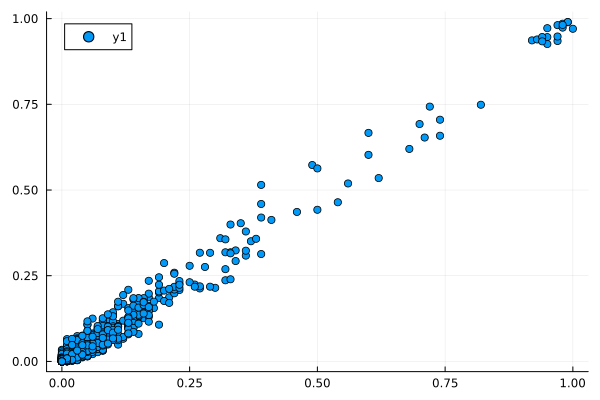

In [128]:
scatter(f_sil[:], f[:])

In [82]:

plot([i*100 for i in 1:length(f_sil)], [corspearman(f, ff) for ff in f_sil], xaxis=:log)
ylims!(0,1)

LoadError: UndefVarError: `f_sil` not defined

In [42]:
site = 19
aa = 4
frs = [reshape(ff, (21, 76)) for ff in f_sil];

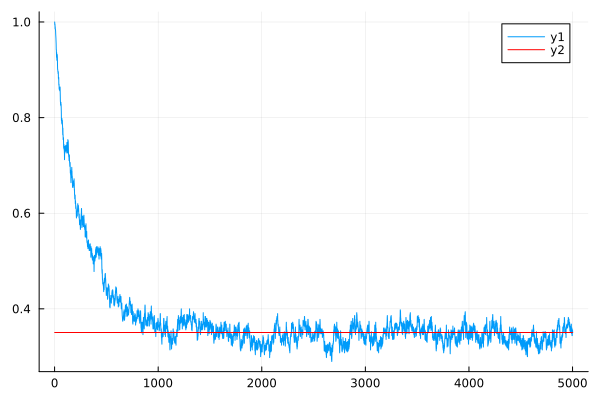

In [43]:
plot([frs[i][aa, site] for i in 1:length(frs)])
plot!([frs_nat[aa,site] for i in 1:length(frs)], color ="red")


In [65]:
energy(h, J, tem_amino_seq)

-10.000551999999923

In [77]:
energy(h, J, pse_amino_seq)

2.6803700000001065

In [78]:
Delta_energy(h, J, tem_amino_seq, pse_amino_seq)

3.6244999999999994

In [105]:
J[:,:,10,11]

21×21 Matrix{Float64}:
 -0.015961  -0.014831  -0.005538  …  -0.007021  -0.133209  -0.015676
 -0.038905   0.118636  -0.006762     -0.008233   0.07311   -0.019274
  0.010567   0.011048  -0.000998     -0.001245  -0.031673  -0.002911
  0.007543   0.043617   0.0125       -0.005496  -0.065573  -0.010788
 -0.007756   0.02523   -0.001256     -0.001642   0.026561  -0.003951
 -0.163856  -0.092762  -0.100294  …   0.039882   0.502764  -0.255877
  0.037391   0.0024    -0.005608     -0.0068    -0.0835    -0.014381
 -0.012434   0.001146  -0.002653     -0.003334  -0.093344  -0.008594
 -0.011641   0.003743  -0.002162     -0.002789  -0.007035  -0.007635
 -0.006864   0.010004  -0.001164     -0.001393  -0.005298  -0.003453
 -0.000701  -0.000677  -7.8e-5    …  -0.00012   -0.004253  -0.000336
  0.00903   -0.02366    0.012721      0.011855   0.037654   0.003091
  0.015874  -0.000977  -0.000147     -0.000186  -0.006572  -0.000591
 -0.008194  -0.008081  -0.001432     -0.001818   0.0044    -0.004201
  0.00224  

In [107]:
maximum(J)

1.959042

In [108]:
energy(h, J, nat_MSA[1,:])

26.124778000000056

In [123]:
new_seq = deepcopy(nat_MSA[1,:])
new_seq[11] = 15
energy(h,J,new_seq) - energy(h,J,nat_MSA[1,:])

-0.5274560000000221

In [124]:
Delta_energy(h,J,new_seq,nat_MSA[1,:])

-0.5274560000000004

In [130]:
final_dbd = step_matrices[end];

In [144]:
h_dbd = h;
J_dbd = permutedims(J, [1,3,2,4]);


In [146]:
@save "../../pars_dbd.jld2" h_dbd J_dbd

In [133]:
step_matrices[1][1,:]

76-element Vector{Int8}:
  2
 10
 18
  2
  6
  3
 15
  1
 16
  6
 20
  7
 20
  ⋮
  6
 11
 11
  9
  4
  6
 18
 15
  9
  3
 15
 12

In [142]:
sum(abs2,J)

2595.5694511775364

In [143]:
h_dbd

21×76 Matrix{Float64}:
 -10.9405   -0.304672   -5.06461   …   -4.95032  -10.7038    -11.1097
   0.0      -2.5427     -5.3223        -6.70359  -10.7037    -11.1096
 -10.9405   -2.50419    -7.01103       -1.91371  -10.7037    -11.1096
 -10.9405   -1.03913   -10.4962        -1.97022   -4.97155   -11.1096
 -10.9404   -3.12694    -6.95536       -6.52014  -10.7037    -11.1097
 -10.9404   -1.48351    -5.83198   …   -2.12072  -10.7037    -11.1097
 -10.9405   -2.35737   -10.4963        -4.02598   -6.82904   -11.1097
 -10.9405   -2.0889     -0.627596      -7.26832  -10.7038    -11.1096
 -10.9405   -0.117441  -10.4962        -2.86427   -3.06479    -5.36071
 -10.9405    0.0        -6.49249       -5.63441  -10.7037    -11.1097
 -10.9405   -2.13294    -6.71582   …   -6.92194  -10.7038    -11.1096
 -10.9405   -2.94122    -8.05171       -2.64577   -6.94081    -5.70876
 -10.9405   -1.53244   -10.2867        -4.2971   -10.7038    -11.1096
 -10.9405   -0.464914  -10.4963        -4.08192   -5.72074    -4.